In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.tree import DecisionTreeRegressor
from sklearn.model_selection import TimeSeriesSplit, cross_val_score, RandomizedSearchCV

from sklearn.model_selection import GridSearchCV
from sklearn.preprocessing import StandardScaler
from sklearn.cluster import KMeans
from sklearn.metrics import r2_score

import lightgbm as lgb

In [59]:
train_data = pd.read_csv('data/train.csv')
test_data = pd.read_csv('data/test.csv')

print(train_data.head())
print(test_data.head())

   time         A         B         C         D         E         F         G  \
0     0  0.207366 -0.159951 -0.634176 -0.580962 -0.266505  0.060173 -0.475257   
1     1  0.188828 -0.265508  0.042143 -0.550442 -0.132319 -0.185219  0.028295   
2     2 -0.144261 -0.577142 -0.214634 -0.747391 -0.184255 -0.464831 -0.085181   
3     3  0.208982 -0.310449  0.513708 -0.562868  0.742308 -0.305487  0.762246   
4     4  0.093320 -0.358156  0.173188 -0.687296 -0.161461 -0.116062 -0.245748   

          H         I         J         K         L         M         N  \
0 -1.486516 -0.332594 -0.671466 -0.226149 -0.187624 -0.780237 -0.785965   
1  0.093210 -0.518139 -0.251917 -0.347845 -0.359069 -0.161254  0.020401   
2  0.700449 -0.603438  0.197773 -0.566696 -0.580799  0.202726  0.135261   
3  1.363020 -0.384575  0.525556 -0.348514 -0.428099  0.548993  0.471031   
4  0.863372 -0.655588 -0.263358 -0.557428 -0.481214  0.083602  0.003087   

         Y1        Y2  
0 -0.935902 -0.310081  
1 -0.089707 -0

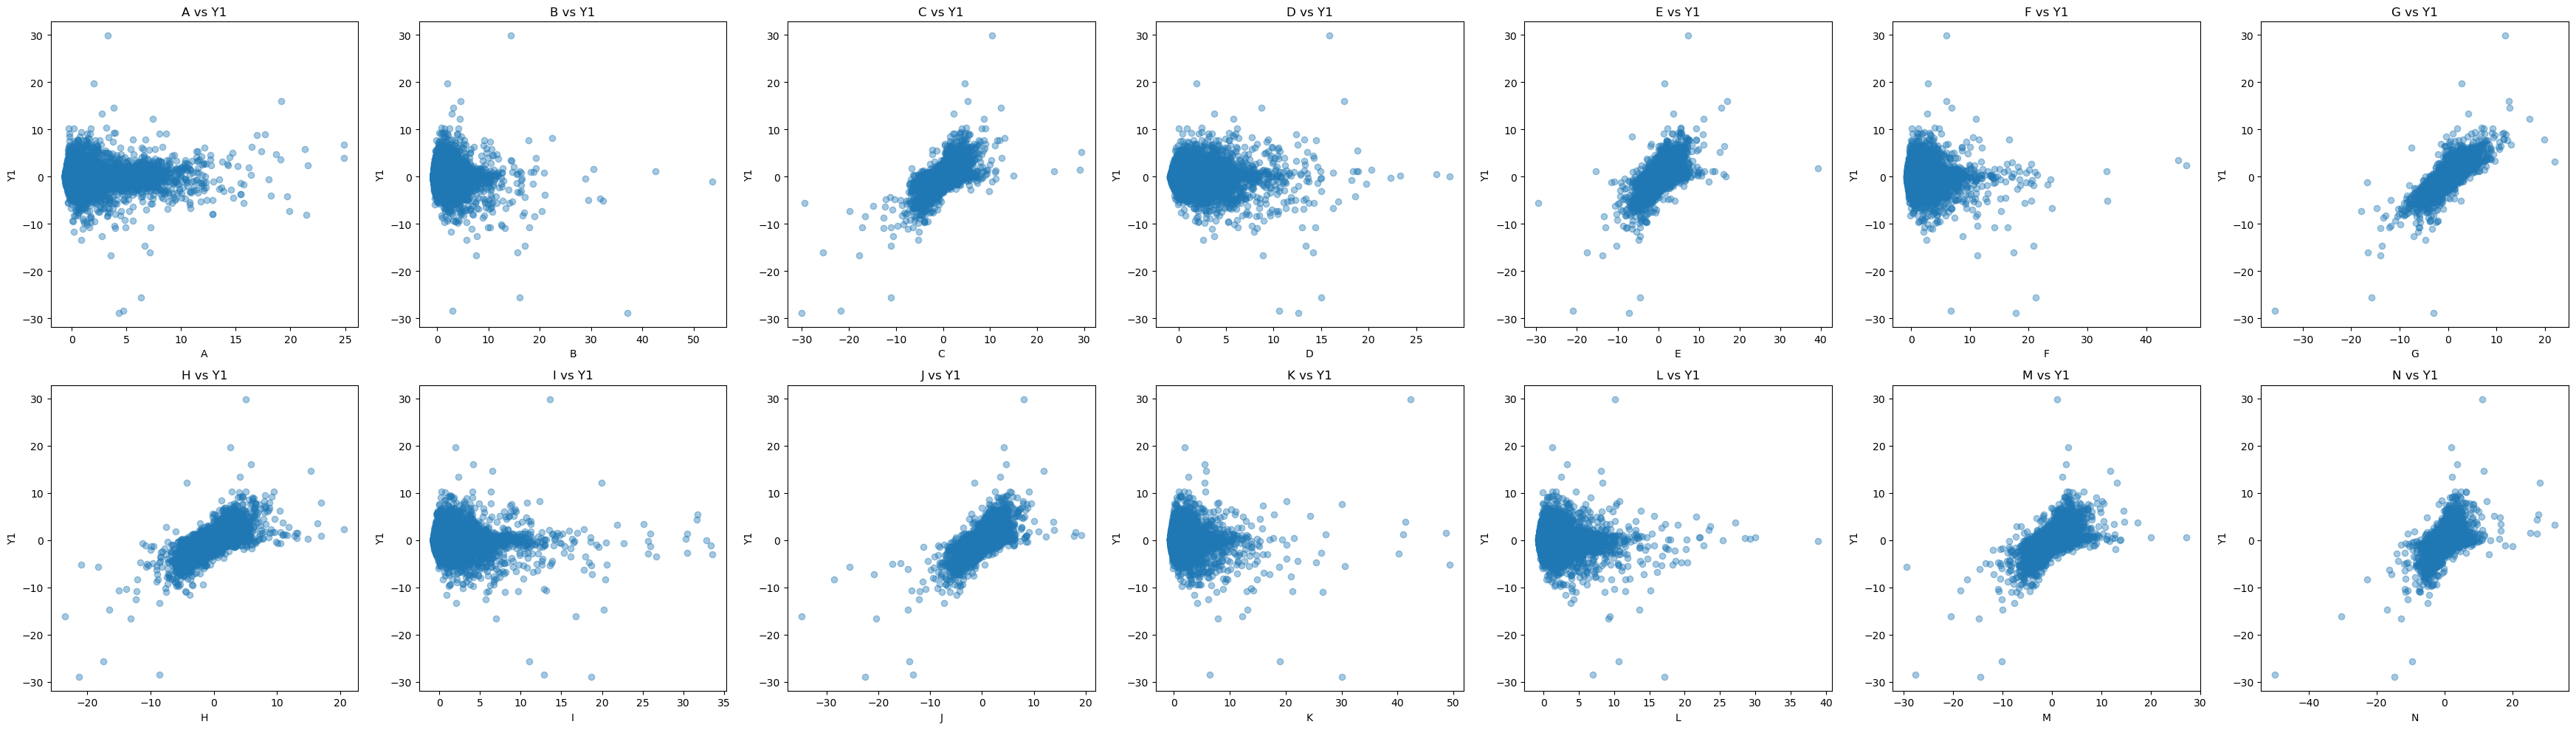

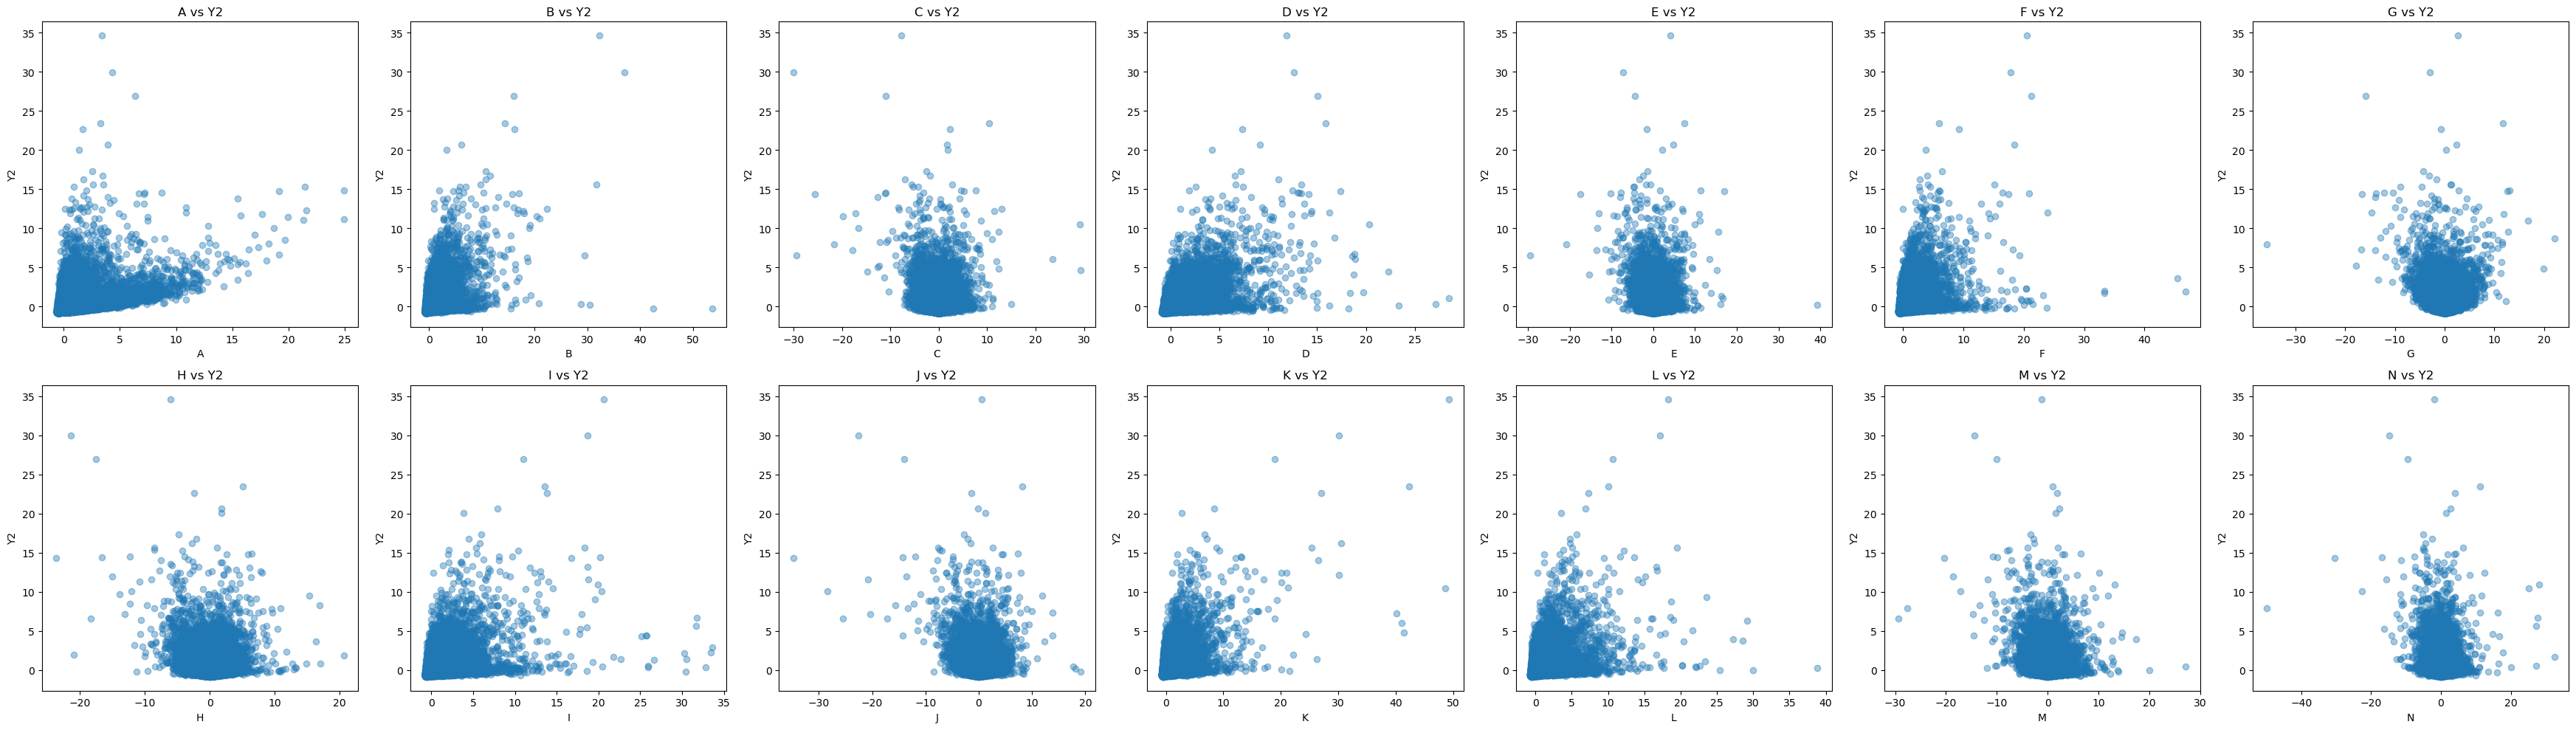

In [47]:
cols = ['A', 'B', 'C', 'D', 'E', 'F', 'G', 'H', 'I', 'J', 'K', 'L', 'M', 'N']

def plot_scatter(axes, row, col, feature, target):
    axes[row, col].scatter(train_data[feature], train_data[target], alpha=0.4)
    axes[row, col].set_xlabel(feature)
    axes[row, col].set_ylabel(target)
    axes[row, col].set_title(f"{feature} vs {target}")

targets = ['Y1', 'Y2']
for t_idx, target in enumerate(targets):
    fig, axes = plt.subplots(nrows=2, ncols=7, figsize=(35,10))
    for idx, feature in enumerate(cols):
        row, col = divmod(idx, 7)
        plot_scatter(axes, row, col, feature, target)
    plt.tight_layout()
    plt.show()


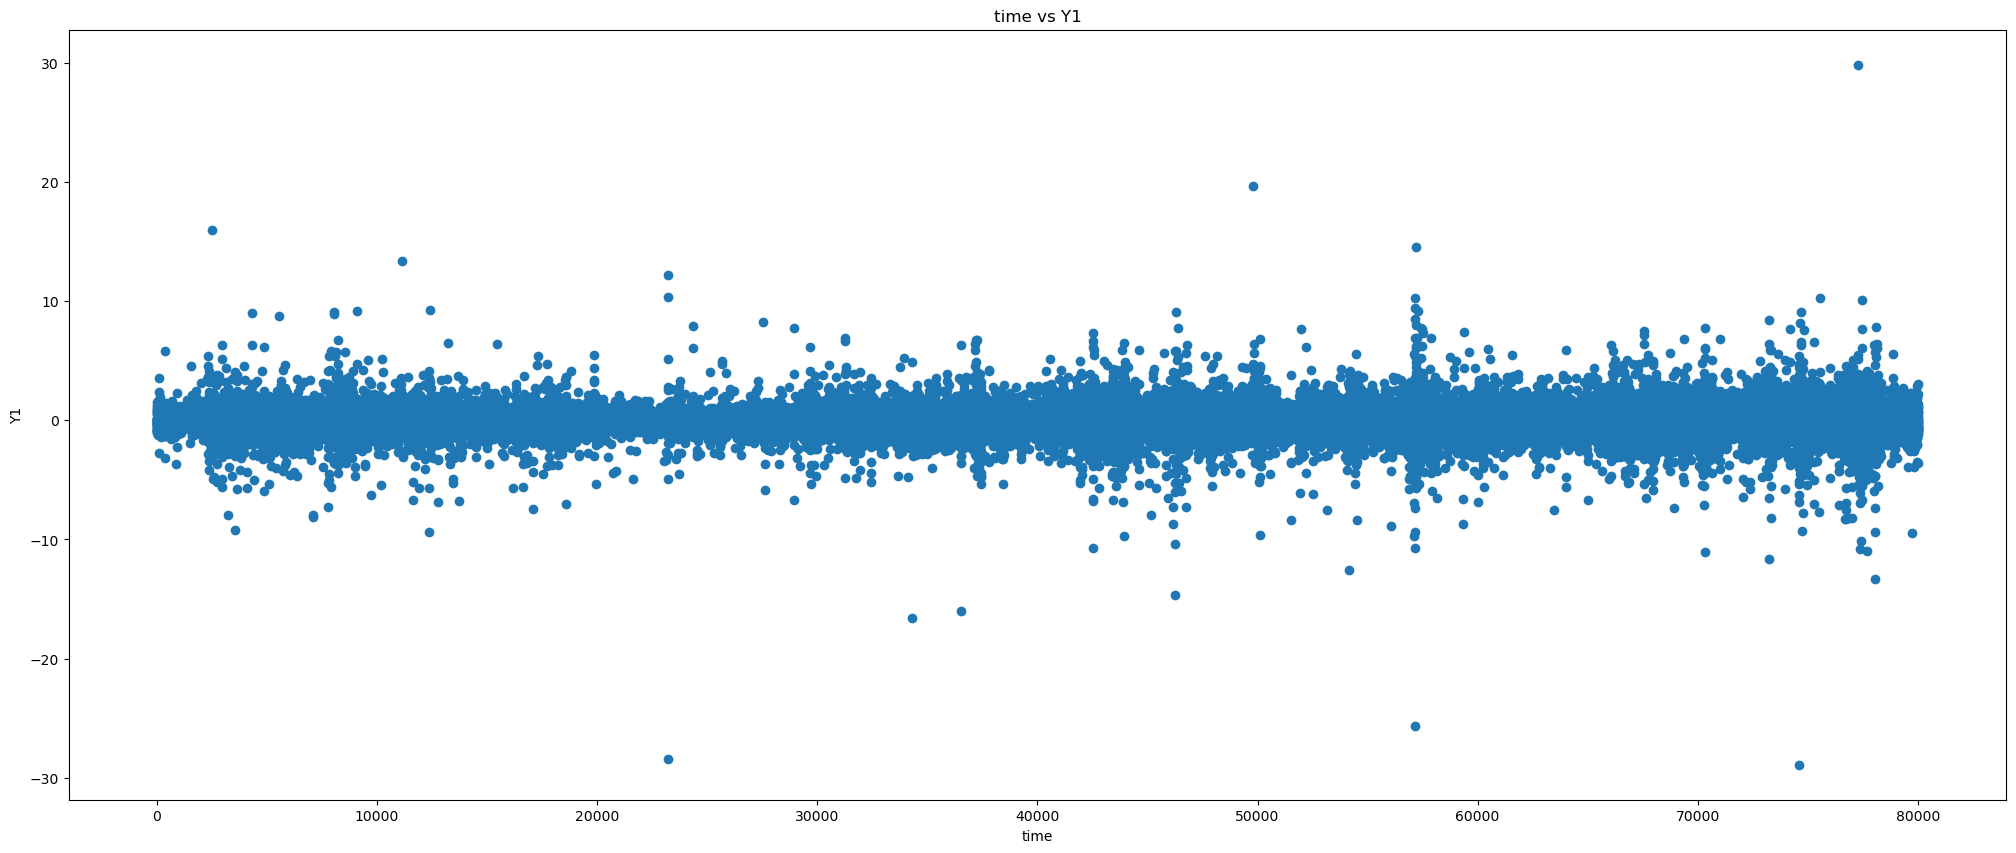

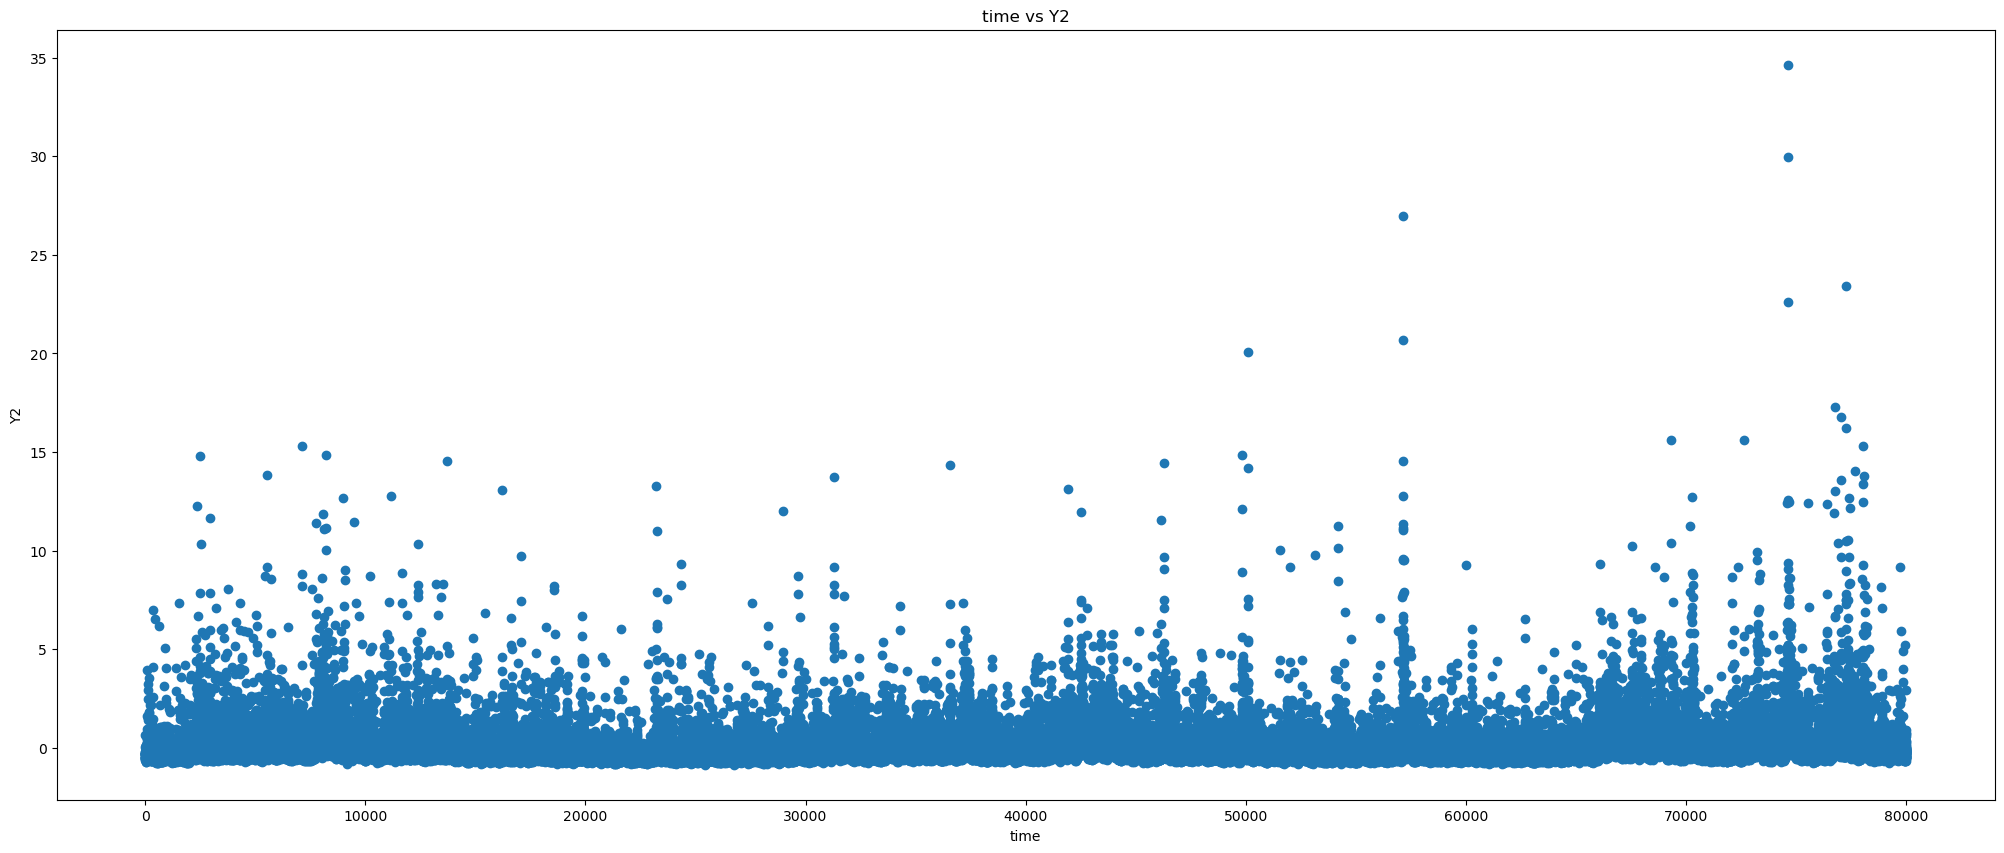

In [53]:
plt.figure(figsize=(25, 10))
plt.scatter(train_data['time'], train_data['Y1'])
plt.xlabel('time')
plt.ylabel('Y1')
plt.title('time vs Y1')
plt.show()

plt.figure(figsize=(25, 10))
plt.scatter(train_data['time'], train_data['Y2'])
plt.xlabel('time')
plt.ylabel('Y2')
plt.title('time vs Y2')
plt.show()

In [27]:
training = train_data.drop(columns=["time","C","E","G","H","J","M","N","Y1","Y2"])
predicted_vals = train_data["Y1"]


regression_model = DecisionTreeRegressor(max_depth=5, random_state=2)

ts_cross_val = TimeSeriesSplit(n_splits = 10)

accuracy = cross_val_score(regression_model, training, predicted_val, cv=ts_cross_val, scoring = "r2")

print("r^2 in fold", accuracy)



r^2 in fold [0.0617597  0.1827326  0.32186122 0.0053781  0.29321201 0.29802889
 0.33298013 0.31379845 0.26834028 0.24005432]


In [25]:
k = {"max_depth": range(1, 20)}

grid = GridSearchCV(DecisionTreeRegressor(random_state=1),
                    param_grid=k,
                    cv=TimeSeriesSplit(n_splits=10),
                    scoring="r2")


grid.fit(training,predicted_val)

,estimator,DecisionTreeR...andom_state=1)
,param_grid,"{'max_depth': range(1, 20)}"
,scoring,'r2'
,n_jobs,None
,refit,True
,cv,TimeSeriesSpl...est_size=None)
,verbose,0
,pre_dispatch,'2*n_jobs'
,error_score,nan
,return_train_score,False
,criterion,'squared_error'


In [26]:
results = pd.DataFrame(grid.cv_results_)
test_model = grid.best_estimator_
print(results)

results.to_csv("results.csv")

    mean_fit_time  std_fit_time  mean_score_time  std_score_time  \
0        0.024874      0.013662         0.001006        0.000215   
1        0.049176      0.025978         0.001141        0.000245   
2        0.068014      0.037253         0.001153        0.000576   
3        0.088563      0.048680         0.001105        0.000188   
4        0.105612      0.057678         0.001085        0.000220   
5        0.122721      0.067806         0.001120        0.000217   
6        0.141411      0.076542         0.001437        0.000832   
7        0.156435      0.085478         0.001197        0.000177   
8        0.173617      0.097926         0.001480        0.000721   
9        0.186718      0.101921         0.001206        0.000223   
10       0.212641      0.113427         0.001351        0.000302   
11       0.216706      0.115645         0.001274        0.000258   
12       0.227026      0.124848         0.001273        0.000237   
13       0.240685      0.132715         0.001429

In [10]:
training1 = train_data.drop(columns=["time","Y1","Y2"])
y1 = train_data["Y1"]
y2 = train_data["Y2"]
y1y2 = train_data[["Y1","Y2"]]

In [ ]:

parameters = {"num_leaves": [4, 32, 64],
              "learning_rate": [0.01, 0.05, 0.09],
              "n_estimators": [100, 400, 700],
              "max_depth": [2,5,8]}

grid = RandomizedSearchCV(lgb.LGBMRegressor(objective="regression", random_state=1),
                    param_distributions=parameters,
                    cv=TimeSeriesSplit(n_splits=3),
                    scoring="r2",
                    n_jobs=-1,
                    n_iter = 30)

grid.fit(training1,y1)

print("best param for Y1", grid.best_params_)
print("best cross val r2", grid.best_score_)

/Library/Frameworks/Python.framework/Versions/3.13/lib/python3.13/site-packages/sklearn/model_selection/_search.py:317: UserWarning: The total space of parameters 27 is smaller than n_iter=30. Running 27 iterations. For exhaustive searches, use GridSearchCV.
  warnings.warn(


[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.011426 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 3570
[LightGBM] [Info] Number of data points in the train set: 20000, number of used features: 14
[LightGBM] [Info] Start training from score 0.002423
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.004270 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 3570
[LightGBM] [Info] Number of data points in the train set: 20000, number of used features: 14
[LightGBM] [Info] Start training from score 0.002423
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.001501 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 3570
[LightGBM] [Info] Number of data points in the train set: 40000, number of used features: 14
[LightGBM] [Info] Start tra

Exception ignored on calling ctypes callback function <function _log_callback at 0x10d17d440>:
Traceback (most recent call last):
  File "/Library/Frameworks/Python.framework/Versions/3.13/lib/python3.13/site-packages/lightgbm/basic.py", line 287, in _log_callback
    def _log_callback(msg: bytes) -> None:
KeyboardInterrupt: 
Exception ignored on calling ctypes callback function <function _log_callback at 0x10bd8d440>:
Traceback (most recent call last):
  File "/Library/Frameworks/Python.framework/Versions/3.13/lib/python3.13/site-packages/lightgbm/basic.py", line 287, in _log_callback
    def _log_callback(msg: bytes) -> None:
KeyboardInterrupt: 
Exception ignored on calling ctypes callback function <function _log_callback at 0x12d591440>:
Traceback (most recent call last):
  File "/Library/Frameworks/Python.framework/Versions/3.13/lib/python3.13/site-packages/lightgbm/basic.py", line 287, in _log_callback
    def _log_callback(msg: bytes) -> None:
KeyboardInterrupt: 
Exception ignore

KeyboardInterrupt: 

In [ ]:
parameters2 = {"num_leaves": [31],
              "learning_rate": [0.01],
              "n_estimators": [600],
              "max_depth": [5]}


grid2 = GridSearchCV(lgb.LGBMRegressor(objective="regression", random_state=1),
                    param_grid=parameters2,
                    cv=TimeSeriesSplit(n_splits=3),
                    scoring="r2",
                    n_jobs=-1,)

grid2.fit(training1,y1)

print("best param for Y1", grid2.best_params_)
print("best cross val r2", grid2.best_score_)


[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.000949 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 3570
[LightGBM] [Info] Number of data points in the train set: 20000, number of used features: 14
[LightGBM] [Info] Start training from score 0.002423
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.001112 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 3570
[LightGBM] [Info] Number of data points in the train set: 40000, number of used features: 14
[LightGBM] [Info] Start training from score 0.000381
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.001307 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 3570
[LightGBM] [Info] Number of data points in the train set: 60000, number of used features: 14
[LightGBM] [Info] Start tra

In [44]:
test_data["Y1"] = np.nan
test_data["Y2"] = np.nan
testing = test_data.drop(columns=["time","id","Y1","Y2"])

print(testing)

              A         B         C         D         E         F         G  \
0     -0.371888 -0.273485  0.538326 -0.377691  1.283159 -0.286957  0.439415   
1     -0.459598 -0.514915 -0.235153 -0.262379  0.044343 -0.429888 -0.059034   
2     -0.381609 -0.265023 -0.629131 -0.186288 -0.146302 -0.357875  0.114223   
3     -0.371423 -0.106279 -1.142702 -0.200429 -0.176918 -0.354048 -0.230199   
4     -0.309393 -0.015144 -1.099371 -0.405841 -0.239068 -0.403306 -0.983134   
...         ...       ...       ...       ...       ...       ...       ...   
15991 -0.453361 -0.196443 -0.050846 -0.447012 -0.077724 -0.592894 -0.161817   
15992 -0.481709 -0.258110 -0.454017 -0.603110  0.040541 -0.508827 -0.062558   
15993 -0.457018 -0.300467  0.403098 -0.555525  0.255084 -0.561159  0.126289   
15994 -0.366164 -0.059930  0.541362 -0.505980  0.351848 -0.450031 -0.220432   
15995 -0.538641 -0.382445  0.113962 -0.498791  0.697350 -0.629678  0.146723   

              H         I         J         K      

In [72]:
best_params = grid2.best_params_

print(best_params)

model_y1 = lgb.LGBMRegressor(objective="regression",random_states=1,**best_params)
model_y1.fit(training1,y1)

model_y2 = lgb.LGBMRegressor(objective="regression",random_states=1,**best_params)
model_y2.fit(training1,y2)

{'learning_rate': 0.01, 'max_depth': 5, 'n_estimators': 600, 'num_leaves': 31}
[LightGBM] [Warning] Unknown parameter: random_states
[LightGBM] [Warning] Unknown parameter: random_states
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.001106 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 3570
[LightGBM] [Info] Number of data points in the train set: 80000, number of used features: 14
[LightGBM] [Info] Start training from score -0.002807
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning]

,boosting_type,'gbdt'
,num_leaves,31
,max_depth,5
,learning_rate,0.01
,n_estimators,600
,subsample_for_bin,200000
,objective,'regression'
,class_weight,None
,min_split_gain,0.0
,min_child_weight,0.001
,min_child_samples,20


In [79]:
y1_pred = model_y1.predict(testing)
y2_pred = model_y2.predict(testing)

[LightGBM] [Warning] Unknown parameter: random_states
[LightGBM] [Warning] Unknown parameter: random_states


In [82]:
preds = pd.DataFrame({"id":test_data["id"],
                      "Y1":y1_pred,
                      "Y2":y2_pred})

print(preds)

          id        Y1        Y2
0          1  0.421786 -0.372655
1          2 -0.206627 -0.513636
2          3 -0.217119 -0.321663
3          4 -0.372701 -0.185138
4          5 -0.890970 -0.082771
...      ...       ...       ...
15991  15992 -0.260393 -0.381988
15992  15993 -0.131084 -0.513416
15993  15994  0.285146 -0.437956
15994  15995  0.408183 -0.436313
15995  15996  0.318427 -0.476857

[15996 rows x 3 columns]


In [83]:
preds.to_csv('preds.csv', index=False)

In [8]:
training_split_left = train_data.drop(columns=["time","C","E","G","H","J","M","N","Y1","Y2"])
training_split_mid= train_data.drop(columns=["time","A","B","D","F","I","K","L","Y1","Y2"])

In [18]:
for column in train_data:
    correlation = train_data[column].corr(train_data['Y1'])
    print(f"Correlation between {column} and Y1: {correlation:.4f}")

for column in train_data:
    correlation = train_data[column].corr(train_data['Y2'])
    print(f"Correlation between {column} and Y2: {correlation:.4f}")

Correlation between time and Y1: -0.0056
Correlation between A and Y1: -0.0061
Correlation between B and Y1: -0.0950
Correlation between C and Y1: 0.7038
Correlation between D and Y1: -0.0571
Correlation between E and Y1: 0.6843
Correlation between F and Y1: -0.0732
Correlation between G and Y1: 0.8146
Correlation between H and Y1: 0.7076
Correlation between I and Y1: -0.0902
Correlation between J and Y1: 0.7239
Correlation between K and Y1: -0.0802
Correlation between L and Y1: -0.0724
Correlation between M and Y1: 0.6862
Correlation between N and Y1: 0.5958
Correlation between Y1 and Y1: 1.0000
Correlation between Y2 and Y1: -0.0643
Correlation between time and Y2: 0.0591
Correlation between A and Y2: 0.4847
Correlation between B and Y2: 0.5819
Correlation between C and Y2: -0.0730
Correlation between D and Y2: 0.6111
Correlation between E and Y2: -0.0446
Correlation between F and Y2: 0.4967
Correlation between G and Y2: -0.0602
Correlation between H and Y2: -0.0870
Correlation betwe

In [29]:
["C", "E", "G", "H", "J", "M" "N"]

training_y1 = train_data.drop(columns=["time","A","B","D","F","I","K","L","Y1","Y2"])
training_y2 = train_data.drop(columns=["time","C","E","G","H","J","M","N","Y1","Y2"])

In [23]:

parameters = {"num_leaves": [3,4,5],
              "learning_rate": [.04,.05,.06],
              "n_estimators": [300,400,500],
              "max_depth": [7,8,9]}

grid = RandomizedSearchCV(lgb.LGBMRegressor(objective="regression", random_state=1),
                    param_distributions=parameters,
                    cv=TimeSeriesSplit(n_splits=3),
                    scoring="r2",
                    n_jobs=-1,
                    n_iter = 30)

grid.fit(training_y1,y1)

print("best param for Y1", grid.best_params_)
print("best cross val r2", grid.best_score_)

[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.005243 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 1785
[LightGBM] [Info] Number of data points in the train set: 20000, number of used features: 7
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.004804 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Start training from score 0.002423
[LightGBM] [Info] Total Bins 1785
[LightGBM] [Info] Number of data points in the train set: 20000, number of used features: 7
[LightGBM] [Info] Start training from score 0.002423
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.002521 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 1785
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.001242 seconds.
You can set `force

In [34]:
parameters_y1 = {"num_leaves": [4],
              "learning_rate": [0.05],
              "n_estimators": [400],
              "max_depth": [8]}

grid = GridSearchCV(lgb.LGBMRegressor(objective="regression", random_state=1),
                    param_grid=parameters,
                    cv=TimeSeriesSplit(n_splits=3),
                    scoring="r2",
                    n_jobs=-1)

grid.fit(training_y1,y1)

print("best param for Y1", grid.best_params_)
print("best cross val r2", grid.best_score_)

[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.000581 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 1785
[LightGBM] [Info] Number of data points in the train set: 20000, number of used features: 7
[LightGBM] [Info] Start training from score 0.002423
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.000793 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 1785
[LightGBM] [Info] Number of data points in the train set: 60000, number of used features: 7
[LightGBM] [Info] Start training from score -0.000907
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.001114 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 1785
[LightGBM] [Info] Number of data points in the train set: 40000, number of used features: 7
[LightGBM] [Info] Start train

In [28]:
best_params_y1 = grid.best_params_
print(best_params_y1)

{'learning_rate': 0.05, 'max_depth': 8, 'n_estimators': 400, 'num_leaves': 4}


In [39]:
parameters = {"num_leaves": [8],
              "learning_rate": [0.029,0.03,0.031],
              "n_estimators": [460,470,480],
              "max_depth": [6]}

grid_y2 = GridSearchCV(lgb.LGBMRegressor(objective="regression", random_state=1),
                    param_grid=parameters,
                    cv=TimeSeriesSplit(n_splits=5),
                    scoring="r2",
                    n_jobs=-1)

grid_y2.fit(training_y2,y2)

print("best param for Y1", grid_y2.best_params_)
print("best cross val r2", grid_y2.best_score_)

[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.000888 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 1785
[LightGBM] [Info] Number of data points in the train set: 13335, number of used features: 7
[LightGBM] [Info] Start training from score 0.082652
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.000758 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 1785
[LightGBM] [Info] Number of data points in the train set: 26668, number of used features: 7
[LightGBM] [Info] Start training from score -0.102749
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.001923 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 1785
[LightGBM] [Info] Number of data points in the train set:

In [42]:
best_params_y1 = grid.best_params_
best_params_y2 = grid_y2.best_params_

model_corr_y1 = lgb.LGBMRegressor(objective="regression",random_states=1,**best_params_y1)
model_corr_y1.fit(training_y1,y1)

model_corr_y2 = lgb.LGBMRegressor(objective="regression",random_states=1,**best_params_y2)
model_corr_y2.fit(training_y2,y2)

[LightGBM] [Warning] Unknown parameter: random_states
[LightGBM] [Warning] Unknown parameter: random_states
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.000692 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 1785
[LightGBM] [Info] Number of data points in the train set: 80000, number of used features: 7
[LightGBM] [Info] Start training from score -0.002807
[LightGBM] [Warning] Unknown parameter: random_states
[LightGBM] [Warning] Unknown parameter: random_states
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.000589 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 1785
[LightGBM] [Info] Number of data points in the train set: 80000, number of used features: 7
[LightGBM] [Info] Start training from score -0.061172


,boosting_type,'gbdt'
,num_leaves,8
,max_depth,6
,learning_rate,0.03
,n_estimators,460
,subsample_for_bin,200000
,objective,'regression'
,class_weight,None
,min_split_gain,0.0
,min_child_weight,0.001
,min_child_samples,20


In [53]:
testing_corr_split_y1 = test_data.drop(columns=["id","time","C","E","G","H","J","M","N","Y1","Y2"])
testing_corr_split_y2= test_data.drop(columns=["id","time","A","B","D","F","I","K","L","Y1","Y2"])

In [55]:
corr_y1_pred = model_corr_y1.predict(testing_corr_split_y1)
corr_y2_pred = model_corr_y2.predict(testing_corr_split_y2)

[LightGBM] [Warning] Unknown parameter: random_states
[LightGBM] [Warning] Unknown parameter: random_states


In [56]:
new_preds = pd.DataFrame({"id":test_data["id"],
                      "Y1":corr_y1_pred,
                      "Y2":corr_y2_pred})

print(new_preds)

          id        Y1        Y2
0          1 -0.344634  1.052987
1          2 -0.348822 -0.218800
2          3 -0.245998 -0.456894
3          4 -0.049134 -0.470109
4          5 -0.175248 -0.580627
...      ...       ...       ...
15991  15992 -0.382702 -0.168789
15992  15993 -0.500488 -0.286427
15993  15994 -0.429770  0.849014
15994  15995 -0.371101  1.065680
15995  15996 -0.426363  0.799494

[15996 rows x 3 columns]


In [57]:
new_preds.to_csv('new_preds.csv', index=False)

In [60]:
for col in train_data:
    train_data[f"{col}_rolling_mean_5"] = train_data[col].rolling(2).mean()
    train_data[f"{col}_rolling_std_5"] = train_data[col].rolling(2).std()
    train_data[f"{col}_diff1"] = train_data[col].diff(1)

In [61]:
print(train_data)

        time         A         B         C         D         E         F  \
0          0  0.207366 -0.159951 -0.634176 -0.580962 -0.266505  0.060173   
1          1  0.188828 -0.265508  0.042143 -0.550442 -0.132319 -0.185219   
2          2 -0.144261 -0.577142 -0.214634 -0.747391 -0.184255 -0.464831   
3          3  0.208982 -0.310449  0.513708 -0.562868  0.742308 -0.305487   
4          4  0.093320 -0.358156  0.173188 -0.687296 -0.161461 -0.116062   
...      ...       ...       ...       ...       ...       ...       ...   
79995  80000 -0.339802 -0.372094 -0.120952 -0.363438  0.266299 -0.222866   
79996  80001 -0.421921 -0.222554 -0.689585 -0.512266 -0.206562 -0.494450   
79997  80002 -0.467038 -0.282018  0.010707 -0.589594  0.067635 -0.410820   
79998  80003 -0.369710 -0.322384 -0.540326 -0.563206 -0.568736 -0.550024   
79999  80004 -0.304899 -0.047375 -0.932102 -0.229424 -0.474211 -0.336000   

              G         H         I  ...   M_diff1  N_rolling_mean_5  \
0     -0.475257

In [62]:
train_data_ft = train_data.drop(columns=["time","Y1","Y2","Y1_rolling_mean_5","Y2_rolling_mean_5","Y1_rolling_std_5","Y2_rolling_std_5","Y2_diff1","Y1_diff1"])

In [63]:
print(train_data_ft)

              A         B         C         D         E         F         G  \
0      0.207366 -0.159951 -0.634176 -0.580962 -0.266505  0.060173 -0.475257   
1      0.188828 -0.265508  0.042143 -0.550442 -0.132319 -0.185219  0.028295   
2     -0.144261 -0.577142 -0.214634 -0.747391 -0.184255 -0.464831 -0.085181   
3      0.208982 -0.310449  0.513708 -0.562868  0.742308 -0.305487  0.762246   
4      0.093320 -0.358156  0.173188 -0.687296 -0.161461 -0.116062 -0.245748   
...         ...       ...       ...       ...       ...       ...       ...   
79995 -0.339802 -0.372094 -0.120952 -0.363438  0.266299 -0.222866 -0.000358   
79996 -0.421921 -0.222554 -0.689585 -0.512266 -0.206562 -0.494450 -0.197705   
79997 -0.467038 -0.282018  0.010707 -0.589594  0.067635 -0.410820  0.032695   
79998 -0.369710 -0.322384 -0.540326 -0.563206 -0.568736 -0.550024 -0.339077   
79999 -0.304899 -0.047375 -0.932102 -0.229424 -0.474211 -0.336000 -0.573839   

              H         I         J  ...   K_diff1 

In [64]:
for column in train_data:
    correlation = train_data[column].corr(train_data['Y1'])
    print(f"Correlation between {column} and Y1: {correlation:.4f}")

for column in train_data_ft:
    correlation = train_data[column].corr(train_data['Y2'])
    print(f"Correlation between {column} and Y2: {correlation:.4f}")

Correlation between time and Y1: -0.0056
Correlation between A and Y1: -0.0061
Correlation between B and Y1: -0.0950
Correlation between C and Y1: 0.7038
Correlation between D and Y1: -0.0571
Correlation between E and Y1: 0.6843
Correlation between F and Y1: -0.0732
Correlation between G and Y1: 0.8146
Correlation between H and Y1: 0.7076
Correlation between I and Y1: -0.0902
Correlation between J and Y1: 0.7239
Correlation between K and Y1: -0.0802
Correlation between L and Y1: -0.0724
Correlation between M and Y1: 0.6862
Correlation between N and Y1: 0.5958
Correlation between Y1 and Y1: 1.0000
Correlation between Y2 and Y1: -0.0643
Correlation between time_rolling_mean_5 and Y1: -0.0057
Correlation between time_rolling_std_5 and Y1: -0.0074
Correlation between time_diff1 and Y1: -0.0074
Correlation between A_rolling_mean_5 and Y1: 0.0030
Correlation between A_rolling_std_5 and Y1: -0.0037
Correlation between A_diff1 and Y1: -0.0330
Correlation between B_rolling_mean_5 and Y1: -0.048

In [65]:
parameters = {"num_leaves": [64],
              "learning_rate": [.02],
              "n_estimators": [400],
              "max_depth": [9]}

grid = GridSearchCV(lgb.LGBMRegressor(objective="regression", random_state=1),
                    param_grid=parameters,
                    #cv=TimeSeriesSplit(n_splits=3),
                    scoring="r2",
                    n_jobs=-1)

grid.fit(train_data_ft,y1)

print("best param for Y1", grid.best_params_)
print("best cross val r2", grid.best_score_)

[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.010054 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 14535
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.006082 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 14535
[LightGBM] [Info] Number of data points in the train set: 64000, number of used features: 57
[LightGBM] [Info] Number of data points in the train set: 64000, number of used features: 57
[LightGBM] [Info] Start training from score -0.002290
[LightGBM] [Info] Start training from score -0.001854
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.008764 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 14535
[LightGBM] [Info] Number of data points in the train set: 64000, number of used features: 57
[LightGBM] [Info] Auto

In [66]:
parameters_y2 = {"num_leaves": [60],
              "learning_rate": [.01],
              "n_estimators": [500],
              "max_depth": [6]}

grid_y2 = GridSearchCV(lgb.LGBMRegressor(objective="regression", random_state=1),
                    param_grid=parameters_y2,
                    #cv=TimeSeriesSplit(n_splits=3),
                    scoring="r2",
                    n_jobs=-1)

grid_y2.fit(train_data_ft,y2)

print("best param for Y1", grid_y2.best_params_)
print("best cross val r2", grid_y2.best_score_)

[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.004758 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 14535
[LightGBM] [Info] Number of data points in the train set: 64000, number of used features: 57
[LightGBM] [Info] Start training from score -0.004187
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.004757 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 14535
[LightGBM] [Info] Number of data points in the train set: 64000, number of used features: 57
[LightGBM] [Info] Start training from score -0.073259
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.009254 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 14535
[LightGBM] [Info] Number of data points in the train set: 64000, number of used features: 57
[LightGBM] [Info] Star

In [67]:
model_feature_y1 = lgb.LGBMRegressor(objective="regression",
                                  random_state=1,
                                  **grid.best_params_)
model_feature_y1.fit(train_data_ft, y1)

model_feature_y2 = lgb.LGBMRegressor(objective="regression",
                                  random_state=1,
                                  **grid_y2.best_params_)
model_feature_y2.fit(train_data_ft, y2)

[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.005081 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 14535
[LightGBM] [Info] Number of data points in the train set: 80000, number of used features: 57
[LightGBM] [Info] Start training from score -0.002807
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gai

,boosting_type,'gbdt'
,num_leaves,60
,max_depth,6
,learning_rate,0.01
,n_estimators,500
,subsample_for_bin,200000
,objective,'regression'
,class_weight,None
,min_split_gain,0.0
,min_child_weight,0.001
,min_child_samples,20


In [70]:
for col in test_data:
    test_data[f"{col}_rolling_mean_5"] = test_data[col].rolling(2).mean()
    test_data[f"{col}_rolling_std_5"] = test_data[col].rolling(2).std()
    test_data[f"{col}_diff1"] = test_data[col].diff(1)

In [69]:
test_data = pd.read_csv('data/test.csv')

In [71]:
print(test_data)

          id   time         A         B         C         D         E  \
0          1  80005 -0.371888 -0.273485  0.538326 -0.377691  1.283159   
1          2  80006 -0.459598 -0.514915 -0.235153 -0.262379  0.044343   
2          3  80007 -0.381609 -0.265023 -0.629131 -0.186288 -0.146302   
3          4  80008 -0.371423 -0.106279 -1.142702 -0.200429 -0.176918   
4          5  80009 -0.309393 -0.015144 -1.099371 -0.405841 -0.239068   
...      ...    ...       ...       ...       ...       ...       ...   
15991  15992  95996 -0.453361 -0.196443 -0.050846 -0.447012 -0.077724   
15992  15993  95997 -0.481709 -0.258110 -0.454017 -0.603110  0.040541   
15993  15994  95998 -0.457018 -0.300467  0.403098 -0.555525  0.255084   
15994  15995  95999 -0.366164 -0.059930  0.541362 -0.505980  0.351848   
15995  15996  96000 -0.538641 -0.382445  0.113962 -0.498791  0.697350   

              F         G         H  ...   K_diff1  L_rolling_mean_5  \
0     -0.286957  0.439415  0.020831  ...       NaN 

In [72]:
print(test_data.columns.tolist())
print(train_data_ft.columns.tolist())

['id', 'time', 'A', 'B', 'C', 'D', 'E', 'F', 'G', 'H', 'I', 'J', 'K', 'L', 'M', 'N', 'id_rolling_mean_5', 'id_rolling_std_5', 'id_diff1', 'time_rolling_mean_5', 'time_rolling_std_5', 'time_diff1', 'A_rolling_mean_5', 'A_rolling_std_5', 'A_diff1', 'B_rolling_mean_5', 'B_rolling_std_5', 'B_diff1', 'C_rolling_mean_5', 'C_rolling_std_5', 'C_diff1', 'D_rolling_mean_5', 'D_rolling_std_5', 'D_diff1', 'E_rolling_mean_5', 'E_rolling_std_5', 'E_diff1', 'F_rolling_mean_5', 'F_rolling_std_5', 'F_diff1', 'G_rolling_mean_5', 'G_rolling_std_5', 'G_diff1', 'H_rolling_mean_5', 'H_rolling_std_5', 'H_diff1', 'I_rolling_mean_5', 'I_rolling_std_5', 'I_diff1', 'J_rolling_mean_5', 'J_rolling_std_5', 'J_diff1', 'K_rolling_mean_5', 'K_rolling_std_5', 'K_diff1', 'L_rolling_mean_5', 'L_rolling_std_5', 'L_diff1', 'M_rolling_mean_5', 'M_rolling_std_5', 'M_diff1', 'N_rolling_mean_5', 'N_rolling_std_5', 'N_diff1']
['A', 'B', 'C', 'D', 'E', 'F', 'G', 'H', 'I', 'J', 'K', 'L', 'M', 'N', 'time_rolling_mean_5', 'time_rol

In [73]:
test_data = test_data.drop(columns=["id","time","id_rolling_mean_5",'id_rolling_std_5','id_diff1'])

In [74]:
print(test_data)

              A         B         C         D         E         F         G  \
0     -0.371888 -0.273485  0.538326 -0.377691  1.283159 -0.286957  0.439415   
1     -0.459598 -0.514915 -0.235153 -0.262379  0.044343 -0.429888 -0.059034   
2     -0.381609 -0.265023 -0.629131 -0.186288 -0.146302 -0.357875  0.114223   
3     -0.371423 -0.106279 -1.142702 -0.200429 -0.176918 -0.354048 -0.230199   
4     -0.309393 -0.015144 -1.099371 -0.405841 -0.239068 -0.403306 -0.983134   
...         ...       ...       ...       ...       ...       ...       ...   
15991 -0.453361 -0.196443 -0.050846 -0.447012 -0.077724 -0.592894 -0.161817   
15992 -0.481709 -0.258110 -0.454017 -0.603110  0.040541 -0.508827 -0.062558   
15993 -0.457018 -0.300467  0.403098 -0.555525  0.255084 -0.561159  0.126289   
15994 -0.366164 -0.059930  0.541362 -0.505980  0.351848 -0.450031 -0.220432   
15995 -0.538641 -0.382445  0.113962 -0.498791  0.697350 -0.629678  0.146723   

              H         I         J  ...   K_diff1 

In [75]:
y1_ft_pred = model_feature_y1.predict(test_data)
y2_ft_pred = model_feature_y2.predict(test_data)

In [76]:
testing = pd.read_csv('data/test.csv')

In [78]:
new_ft_preds_7 = pd.DataFrame({"id":testing["id"],
                      "Y1":y1_ft_pred,
                      "Y2":y2_ft_pred})

print(new_ft_preds_7)

          id        Y1        Y2
0          1  0.770784 -0.504993
1          2 -0.236344 -0.364753
2          3 -0.319800 -0.160687
3          4 -0.442755  0.030711
4          5 -0.982313  0.073277
...      ...       ...       ...
15991  15992 -0.266243 -0.176994
15992  15993 -0.135698 -0.373878
15993  15994  0.371613 -0.244172
15994  15995  0.785433 -0.257231
15995  15996  0.409321 -0.310292

[15996 rows x 3 columns]


In [79]:
new_ft_preds_7.to_csv('new_ft_preds_7.csv', index=False)